# 개인 프로젝트 예시


## OPEN API를 활용한 네이버 뉴스 텍스트 분석
- 1. 네이버 오픈 API로 기사 URL 크롤링
- 2. bs4 + selenium으로 기사 제목 및 내용 크롤링

In [1]:
import os
import sys
import urllib.request
import requests

news_data = []
page_count = 5

client_id = "KJKACCZwmz8QlKStuCTn"
client_secret = "5n9ojiieaU"

encText = urllib.parse.quote("아마존")

for idx in range(page_count):
    # json 결과
    url = "https://openapi.naver.com/v1/search/news?query=" + encText + "&start=" + str(idx * 10 + 1)
    # url = "https://openapi.naver.com/v1/search/blog.xml?query=" + encText # xml 결과
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    response = urllib.request.urlopen(request)
    rescode = response.getcode()

    if(rescode==200):
    #    response_body = response.read()
        result = requests.get(response.geturl(),
                              headers={"X-Naver-Client-Id":client_id,
                                       "X-Naver-Client-Secret":client_secret}
                             )
        news_data.append(result.json())
    #    print(response_body.decode('utf-8'))
    else:
        print("Error Code:" + rescode)

### 크롤링한 데이타 살펴보기

- 온라인 json 뷰어 이용하기 : http://jsonviewer.stack.hu/

In [2]:
# print(news_data)
# print(len(news_data))
# print(news_data[0])
# print(news_data[0]['items'])
# print(len(news_data[0]['items']))
# print(news_data[0]['items'][2])
print(news_data[0]['items'][7]['link'])

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=241&aid=0003099482


### 네이버 뉴스 하이퍼링크만 리스트로 저장하기

In [3]:
naver_news_link = []

for page in news_data:
    #print(page)
    page_news_link = []
    
    for item in page['items']:
        #print(item)
        temp_link = item['link']
        #print(temp_link)
        if "naver" in temp_link:
            page_news_link.append(temp_link)
    
    naver_news_link.append(page_news_link)
        

# 사이트 링크만 가져오기
for page in naver_news_link:
    for link in page:
        print(link)

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=052&aid=0001561843
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=020&aid=0003344140
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=241&aid=0003099482
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=009&aid=0004762430
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=031&aid=0000587915
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=422&aid=0000475435
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=018&aid=0004874391
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=025&aid=0003084520
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=018&aid=0004874358
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=057&aid=0001557365
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=001&aid=0012256631
https://www.bbc.com/korean/news-56370091?xtor=AL-73-%5

### 라이브러리 불러오기

In [4]:
import pandas as pd
import numpy as np
from selenium import webdriver
# 진행바 나오는 패키지
from tqdm import tqdm_notebook
import requests
import pickle
import re
import ast

from bs4 import BeautifulSoup 
from urllib.request import urlopen
import urllib
import time

### 셀레니움을 사용하기 위해 가상 크롬드라이버 다운로드
- 크롬 드라이브 다운로드 : https://chromedriver.chromium.org/downloads

In [5]:
from selenium import webdriver

driver = webdriver.Chrome('./driver/chromedriver')

### 수집한 네이버 뉴스 사이트를 방문하여 뉴스 타이틀과 본문내용 가져오기

In [6]:
naver_news_title = []
naver_news_content = []


for n in tqdm_notebook(range(len(naver_news_link))):
    #print(n)
    news_page_title = []
    news_page_content = []
    
    for idx in tqdm_notebook(range(len(naver_news_link[n]))):        
        
    ########### 긁어온 URL로 접속하기 ############    
        try:
            driver.get(naver_news_link[n][idx])
            print(naver_news_link[n][idx])
            
        except:
            print("Timeout!")
            continue        
        
        try:
            response = driver.page_source
            
        except UnexpectedAlertPresentException:
            driver.switch_to_alert().accept()
            print("게시글이 삭제된 경우입니다.")
            continue
        
        soup = BeautifulSoup(response, "html.parser")
        
        ###### 뉴스 타이틀 긁어오기 ######        
        title = None
        
        try:
            item = soup.find('div', class_="article_info")
            title = item.find('h3', class_="tts_head").get_text()
            #print(title)

        except:
            title = "OUTLINK"
        
        #print(title)
        news_page_title.append(title)
        
        
        ###### 뉴스 본문 긁어오기 ######        
        doc = None
        text = ""
                
        data = soup.find_all("div", {"class" : "_article_body_contents"})
        if data:
            for item in data:

                text = text + str(item.find_all(text=True)).strip()
                text = ast.literal_eval(text)
                doc = ' '.join(text)
   
        else:
            doc = "OUTLINK"
            
        news_page_content.append(doc.replace('\n', ' '))

                
    naver_news_title.append(news_page_title)
    naver_news_content.append(news_page_content)

    time.sleep(2)
    
    
print(naver_news_title[0])
print("==================================")
print(naver_news_content[0])

<ipython-input-6-1b13de154505>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(len(naver_news_link))):


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-6-1b13de154505>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(naver_news_link[n]))):


  0%|          | 0/4 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=052&aid=0001561843
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=020&aid=0003344140
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=241&aid=0003099482
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=103&oid=009&aid=0004762430


  0%|          | 0/3 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=031&aid=0000587915
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=422&aid=0000475435
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=018&aid=0004874391


  0%|          | 0/2 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=025&aid=0003084520
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=018&aid=0004874358


  0%|          | 0/3 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=057&aid=0001557365
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=001&aid=0012256631
https://www.bbc.com/korean/news-56370091?xtor=AL-73-%5Bpartner%5D-%5Bnaver%5D-%5Bheadline%5D-%5Bkorean%5D-%5Bbizdev%5D-%5Bisapi%5D


  0%|          | 0/2 [00:00<?, ?it/s]

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=469&aid=0000587673
https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=104&oid=214&aid=0001105505
['아마존 "성 소수자 정신병자로 규정한 책 판매 안 해"', '대한임상보건학회 “정회원사 및 회원사 선정, 해외 판매 지원”', '‘시총 100조’ 쿠팡 미 증시 화려한 데뷔…마켓컬리도 상장 추진', '아마존엔 왜 .ppt 파일이 없을까']
['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    amazon 아마존이 성 소수자를 정신 질환자로 규정한 책을 판매 목록에서 삭제했다. 11 일 월스트리트 저널 보도에 따르면 지난달 공화당의 마르코 루비오 등 4명의 상원의원은 아마존에 성 소수자를 비판하는 서적이 판매 목록에서 사라진 이유를 해명하라고 요구했다. 의원들은 "보수적 미국인의 견해가 아마존에서 환영받지 못하고 있다"며 공식적으로 불만을 제기했다. 이에 아마존은 답변 서한을 보내 "우리는 레즈비언, 게이, 양성애자, 트랜스젠더를 포함한 성 소수자의 정체성을 정신 질환으로 간주하는 책을 판매하지 않기로 했다"고 삭제 이유를 밝혔다. 문제가 된 책은 지난  2018 년 출간된 \'해리가 샐리가 되었을 때\'이다. 대표적인 보수 학자 라이언  T . 앤더슨이 집필한 이 책은 성 정체성을 비롯한 다양한 문제를 보수적인 시선으로 다루고 있다. 아마존은 이에 대해 "우리는 특정 콘텐츠를 판매하지 않을 권리를 가지고 있다. 모든 업체는 우리와 마찬가지로 어떤 선택을 할지 스스로 정하고 있다"고 밝혔다. 그러자 앤더슨 측은 성명을 내고 "아마존은 거대한 힘으로 사상의 시장을 왜곡하려 한다"고 비판했다. 출판 리서치 기관 코덱스 그룹 조

In [7]:
print(naver_news_title[0])

['아마존 "성 소수자 정신병자로 규정한 책 판매 안 해"', '대한임상보건학회 “정회원사 및 회원사 선정, 해외 판매 지원”', '‘시총 100조’ 쿠팡 미 증시 화려한 데뷔…마켓컬리도 상장 추진', '아마존엔 왜 .ppt 파일이 없을까']


In [8]:
print(naver_news_content[0])

['   본문 내용     TV플레이어     // TV플레이어     // flash 오류를 우회하기 위한 함수 추가 function _flash_removeCallback() {}    amazon 아마존이 성 소수자를 정신 질환자로 규정한 책을 판매 목록에서 삭제했다. 11 일 월스트리트 저널 보도에 따르면 지난달 공화당의 마르코 루비오 등 4명의 상원의원은 아마존에 성 소수자를 비판하는 서적이 판매 목록에서 사라진 이유를 해명하라고 요구했다. 의원들은 "보수적 미국인의 견해가 아마존에서 환영받지 못하고 있다"며 공식적으로 불만을 제기했다. 이에 아마존은 답변 서한을 보내 "우리는 레즈비언, 게이, 양성애자, 트랜스젠더를 포함한 성 소수자의 정체성을 정신 질환으로 간주하는 책을 판매하지 않기로 했다"고 삭제 이유를 밝혔다. 문제가 된 책은 지난  2018 년 출간된 \'해리가 샐리가 되었을 때\'이다. 대표적인 보수 학자 라이언  T . 앤더슨이 집필한 이 책은 성 정체성을 비롯한 다양한 문제를 보수적인 시선으로 다루고 있다. 아마존은 이에 대해 "우리는 특정 콘텐츠를 판매하지 않을 권리를 가지고 있다. 모든 업체는 우리와 마찬가지로 어떤 선택을 할지 스스로 정하고 있다"고 밝혔다. 그러자 앤더슨 측은 성명을 내고 "아마존은 거대한 힘으로 사상의 시장을 왜곡하려 한다"고 비판했다. 출판 리서치 기관 코덱스 그룹 조사에 따르면, 아마존은 미국에서 판매되는 전체 도서 판매량의  53 %와 전체 전자책 판매량의  80 %를 점유하고 있다. 이에 따라 아마존 플랫폼에서 특정 서적을 제거할 경우 이는 판매량에 큰 영향을 미치게 된다. YTN   PLUS  정윤주 기자 ( younju @ ytnplus.co.kr ) [저작권자(c)  YTN  &  YTN   plus  무단전재 및 재배포 금지]  ▶ 이 시각 코로나19 확진자 현황을 확인하세요.   ▶ 대한민국 대표 뉴스 채널 YTN 생방송보기   ▶ 네이버에서 YTN 뉴스 채널 구독하기     // 본문 내용  

In [9]:
print(len(naver_news_title[0]))
print(len(naver_news_content[0]))

4
4


### 피클형태로 저장

In [10]:
with open("./data/naver_news_title.pk", "wb") as f:
    pickle.dump(naver_news_title, f)
    
with open("./data/naver_news_content.pk", "wb") as f:
    pickle.dump(naver_news_content, f)

-------------------------------
## 형태소 분석기 제작하기
- 1. 사용할 형태소 분석기 불러오기
- 2. 텍스트 전처리 하기
- 3. 형태소 / POS tagging 하기

### 형태소 불러오기

In [11]:
from konlpy.tag import Mecab
# from konlpy.tag import Okt
import re

mecab = Mecab()
# okt = Okt()

# 경고 알림이 뜨면 모두 무시
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### 텍스트 전처리

In [12]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='cp949') as f:
        for word in f:
            SW.add(word)            
    return SW

def text_tokenizing(doc):    
    # list comprehension을 풀어서 쓴 코드.1)     
#     tokenized_doc = []
    
#     for word in okt.morphs(doc):
#         if word not in SW and len(word) > 1:
#             tokenized_doc.append(word)
    
#     return tokenized_doc    
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]

In [13]:
text = """5G 이동통신망을 빌려 사용하는 ‘5G 알뜰폰’이 올해 도입되고, 내년부터는 의무화된다.
정부는 알뜰폰 사업자(MNVO)가 통신사(MNO)에 통신망을 빌리는 비용(도매대가)을 지난해보다 큰 폭으로 낮춰, 알뜰폰 요금 인하를 유도하기로 했다. 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다.
과학기술정보통신부는 알뜰폰 활성화 추진대책을 25일 발표했다. 알뜰폰 가입자는 800만명으로 이동통신 시장의 12%를 차지한다. 2011년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다. 하지만 지난해 5월 통신 3사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다.
우선 올해 안에 3개 이상의 5G 알뜰폰이 시장에 나온다. 통신사가 5G망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다. 앞서 LG유플러스는 오는 10월 알뜰폰 사업을 시작하는 KB국민은행에 5G망을 제공한다고 밝힌 바 있다. SK텔레콤와 KT도 특정 제휴사를 선택해 올해 안에 5G 알뜰폰을 내놓기로 했다.
내년부터는 5G 알뜰폰 제공이 의무화된다. 지난 22일자로 종료된 도매제공 의무제도의 유효기간을 2022년 9월22일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면, 관련 고시를 개정해 SK텔레콤의 5G망 도매제공을 의무화하겠다는 것이다.
과기정통부 관계자는 “SK텔레콤이 자사와 계약을 맺은 13개 알뜰폰 사업자에게 5G망을 의무 제공하면, 그 외 31개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 KT와 LG유플러스도 5G망을 제공하게 될 것”이라고 내다봤다.
알뜰폰 사업자가 상품을 만드는 방식 크게 2가지다. 하나는 통신사로부터 음성·문자·데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식(종량제 도매제공)이다. 이를 위해 정부는 도매대가 인하율을 음성 17.8%, 데이터 19.2%, 단문메시지 1.15%로, 지난해 음성 15.1%, 데이터 19.1%, 단문메시지 1.13%에 비해 높여 잡았다.
또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서, 그 차액의 범위에서 저렴한 요금제를 내놓는 방식(수익배분 도매제공)이다. 정부는 SK텔레콤의 준보편 요금제인 ‘T플랜 요금제’를 알뜰폰 사업자가 재판매할 수 있게 했다. 기존에 SK텔레콤이 도매제공했던 ‘밴드데이터 요금제’의 최고구간의 대가도 1.5%포인트 낮췄다.
알뜰폰 업계는 대체로 반기는 분위기지만, 알뜰폰 시장을 살릴 수 있을지에는 의구심을 갖고 있다. 업계 관계자는 “도매대가 인하율이 크고, 5G망을 제공하는 것은 긍정적”이라면서도 “수익배분 도매제공의 의무화, 설비를 가진 업체에 대한 접속료 정산 도입 등의 제도적 개선이 필요하다”고 말했다."""

In [14]:
SW = define_stopwords("./data/stopwords-ko.txt")

cleaned_text = text_cleaning(text)
print("전처리 결과 : ", cleaned_text)

tokenized_text = text_tokenizing(cleaned_text)
print("\n형태소 분석 결과 : ", tokenized_text)

전처리 결과 :   이동통신망을 빌려 사용하는  알뜰폰이 올해 도입되고 내년부터는 의무화된다정부는 알뜰폰 사업자가 통신사에 통신망을 빌리는 비용도매대가을 지난해보다 큰 폭으로 낮춰 알뜰폰 요금 인하를 유도하기로 했다 하지만 줄어드는 알뜰폰 시장을 살릴 수 있을지는 지켜봐야 하는 상황이다과학기술정보통신부는 알뜰폰 활성화 추진대책을 일 발표했다 알뜰폰 가입자는 만명으로 이동통신 시장의 를 차지한다 년 출시 뒤 저렴한 요금제로 통신비 부담을 낮춰왔다 하지만 지난해 월 통신 사가 준보편제 요금을 내놓은 이후 알뜰폰 이탈 현상이 지속되고 있다우선 올해 안에 개 이상의  알뜰폰이 시장에 나온다 통신사가 망을 알뜰폰 사업자에게 도매 제공할지 여부는 통신사 자율로 정한다 앞서 유플러스는 오는 월 알뜰폰 사업을 시작하는 국민은행에 망을 제공한다고 밝힌 바 있다 텔레콤와 도 특정 제휴사를 선택해 올해 안에  알뜰폰을 내놓기로 했다내년부터는  알뜰폰 제공이 의무화된다 지난 일자로 종료된 도매제공 의무제도의 유효기간을 년 월일까지 연장하는 전기통신사업법 개정안이 국회에서 통과되면 관련 고시를 개정해 텔레콤의 망 도매제공을 의무화하겠다는 것이다과기정통부 관계자는 텔레콤이 자사와 계약을 맺은 개 알뜰폰 사업자에게 망을 의무 제공하면 그 외 개의 알뜰폰 사업자들이 경쟁에서 밀릴 것을 우려해 와 유플러스도 망을 제공하게 될 것이라고 내다봤다알뜰폰 사업자가 상품을 만드는 방식 크게 가지다 하나는 통신사로부터 음성문자데이터를 도매로 사들인 뒤 이를 바탕으로 통신사보다 저렴한 요금제를 내놓는 방식종량제 도매제공이다 이를 위해 정부는 도매대가 인하율을 음성  데이터  단문메시지 로 지난해 음성  데이터  단문메시지 에 비해 높여 잡았다또 다른 방식은 일정비용을 통신사에 내고 통신사의 정액 요금제를 그대로 판매하면서 그 차액의 범위에서 저렴한 요금제를 내놓는 방식수익배분 도매제공이다 정부는 텔레콤의 준보편 요금제인 플랜 요금제를 알뜰폰 사업자가 재판매할 수 있게 했다 기존에 텔레콤이 도매제공했던 

----------------------------
## 피클형태 데이타 읽어와서 빈도 챠트와 워드 클라우드 그리기

### 데이타 전처리와 데이타 불러오기 함수

In [15]:
from tqdm import tqdm_notebook # progress bar
from konlpy.tag import Mecab
# from konlpy.tag import Okt #Okt 등 형태소 분석기 불러오기
import numpy as np
import string # 특수문자
import re
import warnings # 경고 알림 제거
import pickle
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [16]:
def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    
    corpus = []
    
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
        
    for page in temp_corpus:
        corpus += page
    
    return corpus

def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(doc))
    return doc

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1)
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2)
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='cp949') as f:
        for word in f:
            SW.add(word)            
    return SW


def text_tokenizing(doc):
    return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]

In [17]:
input_file_name = "./data/naver_news_content.pk"
documents = read_documents(input_file_name)
# documents

한국의 유니콘이 세계적인 미국 주식 시장에 성공적으로 진출한 것에 대해 보람을 느낀다고 했다.        김 의장은 이날 뉴욕 등 미국 주재 한국 특파원들과의 온라인 간담회에서 “뉴욕증권거래소에 상장한 이유는 전통이 깊고 세계적인 회사들의 커뮤니티에 입성한다는 의미도 있다”며 “한국의 유니콘도 그런 커뮤니티에 들어갈 자격이 된다는 것을 보여주고 싶었다”고 말했다.      김 의장은 “한국의 E커머스 시장 규모가  530 조원이 넘는다. 한국 시장 규모가 절대로 작지 않다”며 “이번 상장 과정에서 가장 보람을 느낀 부분 중 하나가 한국 시장의 규모와 가능성, 그리고 혁신  DNA 를 알릴 좋은 기회였다는 것이다"고 말했다. 그는 또 "전 세계  10 대 E커머스 시장 중 유일하게 아마존과 알리바바가 장악하지 않은 시장이 한국이다"고 강조했다.      김 의장은 확보한 자금으로 “공격적인 투자를 해 좋은 일자리(향후 5년간 5만명 추가 직고용)를 창출하겠다”며 “특히 지역 경제 활성화와 물류 인프라 구축에 지속적으로 투자할 계획이다"고 설명했다.        마켓컬리  CI .           쿠팡이 화려한 미국 데뷔에 자극받은 경쟁사 마켓컬리도 연내 상장을 추진한다고 밝혔다.         12 일 마켓컬리 운영사 컬리에 따르면 김슬아 대표는 최근 팀장급 이상 직원들을 대상으로 연내 상장 추진 계획을 공유했다.      마켓컬리 관계자는 “올해 안에 상장을 추진하는 것은 맞다”며 “한국과 미국 시장 모두 가능성을 열어두고 검토하고 있다"고 말했다.        마켓컬리는  2015 년 문을 연 이커머스 업체로, \'새벽배송\' 서비스로 주부들 사이에서 입소문을 타며 빠르게 성장했다.  2015 년  29 억원 수준이었던 연매출은  2019 년에  4289 억원으로 급등했다. 회원 수는 이달 현재  700 만명을 돌파했으며 총 4개의 물류 센터를 운영하고 있다.        권오용 기자  kwon.ohyong @ joongang.co.kr     ▶ \xa

In [18]:
SW = define_stopwords("./data/stopwords-ko.txt")
# SW

In [19]:
cleaned_text = text_cleaning(documents)
#cleand_text

'   본문 내용     플레이어      플레이어       오류를 우회하기 위한 함수 추가        아마존이 성 소수자를 정신 질환자로 규정한 책을 판매 목록에서 삭제했다  일 월스트리트 저널 보도에 따르면 지난달 공화당의 마르코 루비오 등 명의 상원의원은 아마존에 성 소수자를 비판하는 서적이 판매 목록에서 사라진 이유를 해명하라고 요구했다 의원들은 보수적 미국인의 견해가 아마존에서 환영받지 못하고 있다며 공식적으로 불만을 제기했다 이에 아마존은 답변 서한을 보내 우리는 레즈비언 게이 양성애자 트랜스젠더를 포함한 성 소수자의 정체성을 정신 질환으로 간주하는 책을 판매하지 않기로 했다고 삭제 이유를 밝혔다 문제가 된 책은 지난   년 출간된 해리가 샐리가 되었을 때이다 대표적인 보수 학자 라이언    앤더슨이 집필한 이 책은 성 정체성을 비롯한 다양한 문제를 보수적인 시선으로 다루고 있다 아마존은 이에 대해 우리는 특정 콘텐츠를 판매하지 않을 권리를 가지고 있다 모든 업체는 우리와 마찬가지로 어떤 선택을 할지 스스로 정하고 있다고 밝혔다 그러자 앤더슨 측은 성명을 내고 아마존은 거대한 힘으로 사상의 시장을 왜곡하려 한다고 비판했다 출판 리서치 기관 코덱스 그룹 조사에 따르면 아마존은 미국에서 판매되는 전체 도서 판매량의   와 전체 전자책 판매량의   를 점유하고 있다 이에 따라 아마존 플랫폼에서 특정 서적을 제거할 경우 이는 판매량에 큰 영향을 미치게 된다      정윤주 기자      저작권자           무단전재 및 재배포 금지   이 시각 코로나 확진자 현황을 확인하세요    대한민국 대표 뉴스 채널  생방송보기    네이버에서  뉴스 채널 구독하기      본문 내용       본문 내용     플레이어      플레이어       오류를 우회하기 위한 함수 추가        대한임상보건학회는 국내 중소기업 우수 제품 수출지원의 일환으로    대한임상보건학회 정회원 선정 및 회원사 모집을 차로 진행했다고   일 밝혔다 학회에 따르면 차 대상

In [20]:
tokenized_text = text_tokenizing(cleaned_text)

In [21]:
# tokenized_text

### NLTK를 이용한 histogram 분석

In [22]:
import nltk
print(len(tokenized_text))

3372


In [23]:
from pprint import pprint
text = nltk.Text(tokenized_text, name='naver_news')
print(len(set(tokenized_text)))
pprint(text.vocab().most_common(10))

1106
[('쿠팡', 93),
 ('상장', 57),
 ('아마존', 55),
 ('시장', 42),
 ('미국', 41),
 ('달러', 33),
 ('뉴욕', 31),
 ('증시', 30),
 ('한국', 29),
 ('기업', 28)]


### Histogram 그리기

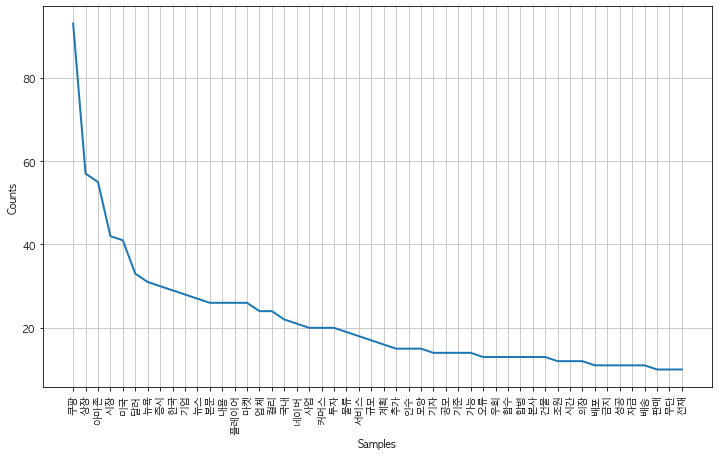

In [24]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(12, 7))
text.plot(50)

### WordCloud 그리기

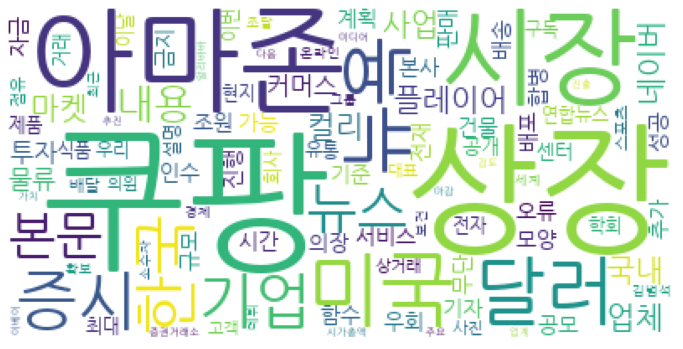

In [25]:
from wordcloud import WordCloud

data = text.vocab().most_common(100)

wordcloud = WordCloud(font_path= '/Library/Fonts/NanumGothic.ttf',
    # font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(12,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 원하는 이미지를 이용한 워드 클라우드 그리기

In [26]:
from wordcloud import ImageColorGenerator
import numpy as np
from PIL import Image

mask = np.array(Image.open('heart.jpg'))
image_colors = ImageColorGenerator(mask)

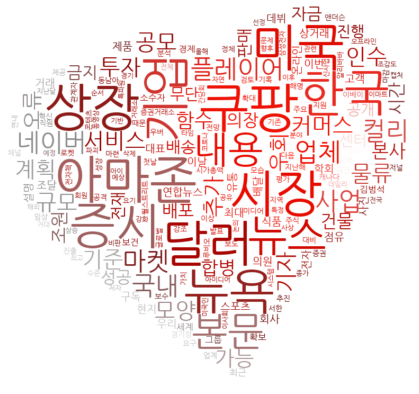

In [27]:
data = text.vocab().most_common(200)

wordcloud = WordCloud(font_path= "/Library/Fonts/NanumGothic.ttf",
    # font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
               relative_scaling = 0.1, mask=mask,
               background_color = 'white',
               min_font_size=1,
               max_font_size=100).generate_from_frequencies(dict(data))

default_colors = wordcloud.to_array()

plt.figure(figsize=(10,7))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation='bilinear')
plt.axis('off')
plt.show()

In [28]:
from tqdm import tqdm_notebook # progress bar
from konlpy.tag import Mecab #Okt 등 형태소 분석기 불러오기
import numpy as np
import string # 특수문자
import re
import warnings # 경고 알림 제거
import pickle
from gensim import corpora
from gensim import models
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [29]:
def read_documents(input_file_name):    
    corpus = []    
    
    with open(input_file_name, 'rb') as f:
        temp_corpus = pickle.load(f)
        
    for page in temp_corpus:
        corpus += page
    
    return corpus

def text_cleaning(docs):
    # 한국어를 제외한 글자를 제거하는 함수.
    for doc in docs:
        doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", str(doc))

    return docs

def define_stopwords(path):    
    SW = set()
    # 불용어를 추가하는 방법 1.
    for i in string.punctuation:
        SW.add(i)
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가    
    with open(path, encoding='cp949') as f:
        for word in f:
            SW.add(word)
    return SW

def text_tokenizing(corpus, tokenizer):    
    mecab = Mecab()
    token_corpus = []    

    if tokenizer == "noun":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = mecab.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]                
            token_corpus.append(token_text)
            
    elif tokenized == "morph":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = mecab.morphs(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)

    elif tokenizer == "word":
        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)        

    return token_corpus

In [31]:
input_file_name = "./data/naver_news_content.pk"
documents = read_documents(input_file_name)
SW = define_stopwords("data/stopwords-ko.txt")
cleaned_text = text_cleaning(documents)
tokenized_text = text_tokenizing(cleaned_text, tokenizer="noun") #tokenizer= "noun" or "word"

Preprocessing:   0%|          | 0/14 [00:00<?, ?it/s]

In [32]:
print(tokenized_text[0])

['본문', '내용', '플레이어', '플레이어', '오류', '우회', '함수', '추가', '아마존', '소수자', '정신', '질환', '규정', '판매', '목록', '삭제', '월스트리트', '저널', '보도', '지난달', '공화', '마르코', '루비오', '상원', '의원', '아마존', '소수자', '비판', '서적', '판매', '목록', '이유', '해명', '요구', '의원', '보수', '미국인', '견해', '아마존', '환영', '공식', '불만', '제기', '아마존', '답변', '서한', '우리', '레즈비언', '게이', '양성애자', '트랜스젠더', '포함', '소수자', '정체', '정신', '질환', '간주', '판매', '삭제', '이유', '문제', '출간', '해리', '샐리', '대표', '보수', '학자', '라이언', '앤더슨', '집필', '정체', '문제', '보수', '시선', '아마존', '우리', '특정', '콘텐츠', '판매', '권리', '업체', '우리', '마찬가지', '선택', '앤더슨', '성명', '아마존', '거대', '사상', '시장', '왜곡', '비판', '출판', '리서치', '기관', '코덱스', '그룹', '조사', '아마존', '미국', '판매', '전체', '도서', '판매량', '전체', '전자책', '판매량', '점유', '아마존', '플랫폼', '특정', '서적', '제거', '경우', '판매량', '영향', '정윤주', '기자', '저작권자', '무단', '전재', '배포', '금지', '시각', '코로나', '확진', '현황', '확인', '대한민국', '대표', '뉴스', '채널', '생방송', '네이버', '뉴스', '채널', '구독', '본문', '내용']


In [33]:
# 어휘(vocabulary) 학습
dictionary = corpora.Dictionary(tokenized_text)

# 문서-단어 행렬(document-term matrix) 생성
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

In [34]:
# TFIDF 문서-단어 행렬 생성
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
corpus_tfidf[0][:5]

[(0, 0.10955757002638086),
 (1, 0.052007080371913456),
 (2, 0.10955757002638086),
 (3, 0.06394988602614503),
 (4, 0.10955757002638086)]

In [35]:
model = models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary)

In [36]:
# 토픽 개수, 키워드 개수를 정해주는 변수를 추가.
NUM_TOPICS = 3 # 토픽의 수

NUM_TOPIC_WORDS = 30 # 키워드 수

def build_doc_term_mat(documents):
    # 문서-단어 행렬 만들어주는 함수.
    print("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    corpus = [dictionary.doc2bow(document) for document in documents]        
    return corpus, dictionary

def print_topic_words(model):
    # 토픽 모델링 결과를 출력해 주는 함수.
    print("\nPrinting topic words.\n")
    
    for topic_id in range(model.num_topics):
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)
        print("Topic ID: {}".format(topic_id))
        
        for topic_word, prob in topic_word_probs:
            print("\t{}\t{}".format(topic_word, prob))            
        print("\n")

In [37]:
# 1) document-term matrix 생성
corpus, dictionary = build_doc_term_mat(tokenized_text)

# 2) LDA 모델 생성
model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS, id2word=dictionary, alpha="auto", eta="auto")

# 3) 결과를 출력.
print_topic_words(model)

Building document-term matrix.

Printing topic words.

Topic ID: 0
	아마존	0.016780782490968704
	쿠팡	0.013184763491153717
	미국	0.010690774768590927
	시장	0.010036719962954521
	상장	0.008608744479715824
	달러	0.00724527845159173
	내용	0.006940938998013735
	마켓	0.0064095095731318
	본문	0.006347251124680042
	플레이어	0.00616961857303977
	업체	0.006033856887370348
	기업	0.005615379195660353
	컬리	0.005111572798341513
	학회	0.004951499402523041
	한국	0.004868455696851015
	모양	0.004792641382664442
	뉴욕	0.004678152035921812
	뉴스	0.00447780592367053
	추가	0.004284379538148642
	국내	0.004099190700799227
	네이버	0.004073700401932001
	서비스	0.00403300765901804
	판매	0.004022415727376938
	건물	0.003973281942307949
	제품	0.003965824376791716
	증시	0.003825388615950942
	보건	0.00379181862808764
	사업	0.003771927673369646
	함수	0.0037270872853696346
	오류	0.003653851803392172


Topic ID: 1
	쿠팡	0.030789772048592567
	아마존	0.01386640127748251
	상장	0.009118773974478245
	미국	0.007769611198455095
	뉴욕	0.007653131615370512
	뉴스	0.006413166411221027
	시장	0.00607121968641

In [39]:
# pyLDAvis 불러오기
import pyLDAvis
import pyLDAvis.gensim

# pyLDAvis를 jupyter notebook에서 실행할 수 있게 활성화.
pyLDAvis.enable_notebook()

# pyLDAvis 실행.
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data

/Users/lisemara/miniforge3/envs/tf/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.017823  0.002959       1        1  45.253925
1     -0.005319 -0.012490       2        1  34.118397
0     -0.012505  0.009530       3        1  20.627677, topic_info=    Term       Freq      Total Category  logprob  loglift
51   아마존  39.000000  39.000000  Default  30.0000  30.0000
176   학회   6.000000   6.000000  Default  29.0000  29.0000
294   쿠팡  77.000000  77.000000  Default  28.0000  28.0000
130   보건   5.000000   5.000000  Default  27.0000  27.0000
160   임상   4.000000   4.000000  Default  26.0000  26.0000
..   ...        ...        ...      ...      ...      ...
15   네이버   2.823441  17.140271   Topic3  -5.5032  -0.2249
107   국내   2.841108  18.729829   Topic3  -5.4970  -0.3074
194   계획   2.521433  13.168178   Topic3  -5.6163  -0.0744
132   사업   2.614285  16.152070   Topic3  -5.5802  -0.2425
495   증시   2.651338  25.508418   Topic3  -5.5661  -0.6854

[235 rows x 6 columns], token_table=      Topic      Freq Term
term                      
183       1  0.428238   가능
183       2  0.513886   가능
183       3  0.171295   가능
871       1  0.450472   개방
871       2  0.450472   개방
...     ...       ...  ...
531       1  0.447752   활동
531       2  0.447752   활동
182       1  0.294906   회원
182       2  0.294906   회원
182       3  0.294906   회원

[384 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])